target
1    100143
0     99857
Name: count, dtype: int64


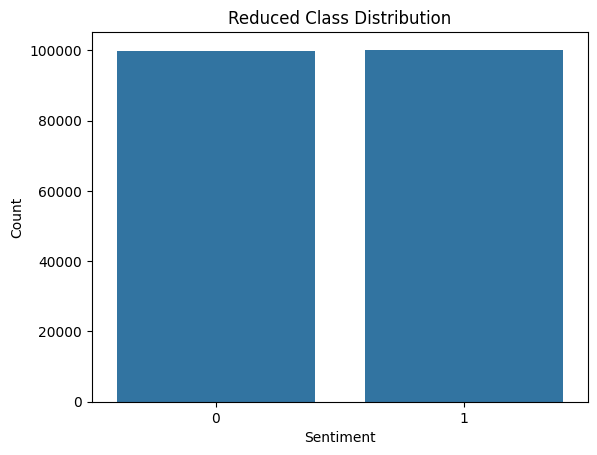

Train size: 100000, Test size: 100000


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the Sentiment140 dataset
df = pd.read_csv('original_data.csv', encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Convert 4 (positive) to 1 and 0 (negative) stays 0
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Reduce the dataset for faster training (~200k samples)
df = df.sample(n=200000, random_state=42)

# Show basic class distribution
print(df['target'].value_counts())

# Optional: Visualize class balance
sns.countplot(x='target', data=df)
plt.title('Reduced Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Split into train and test sets (50-50)
train_df, test_df = train_test_split(
    df,
    test_size=0.5,
    stratify=df['target'],
    random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizer setup
vocab_size = 10000
max_len = 30

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

# Convert text to padded sequences
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

# Get labels
y_train = train_df['target'].values
y_test = test_df['target'].values


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential([
    Embedding(vocab_size, 100),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=3,
    batch_size=64
)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - accuracy: 0.7105 - loss: 0.5459 - val_accuracy: 0.7855 - val_loss: 0.4548
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8090 - loss: 0.4177 - val_accuracy: 0.7947 - val_loss: 0.4451
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8340 - loss: 0.3679 - val_accuracy: 0.7928 - val_loss: 0.4560


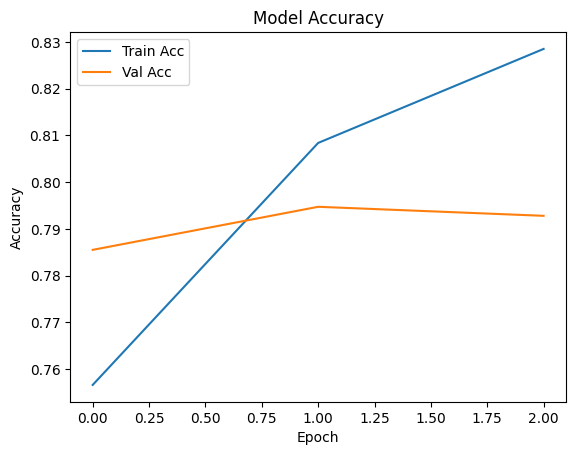

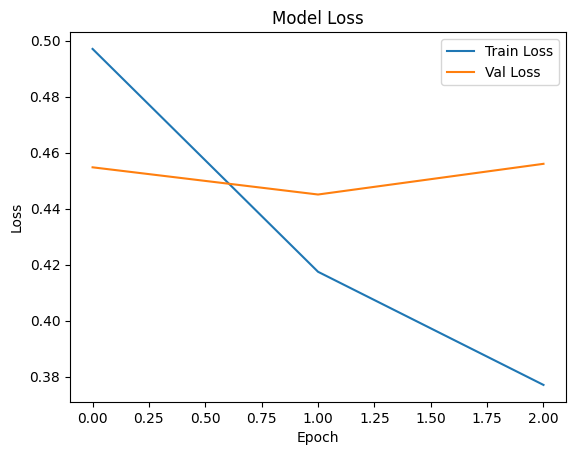

In [9]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step
Test Accuracy: 0.7928
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.81      0.80     49929
    Positive       0.80      0.78      0.79     50071

    accuracy                           0.79    100000
   macro avg       0.79      0.79      0.79    100000
weighted avg       0.79      0.79      0.79    100000



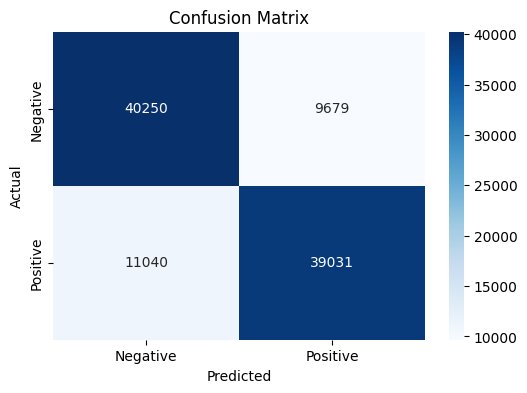

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

# Predict on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Accuracy score
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()